# Model with conditional interaction

In this example, we show the heterogeneity of the global effects, using PDP, ALE, and RHALE, on a model with conditional interactions.
We will use the following model: 

$$ 
f(x_1, x_2, x_3) = -x_1^2 \mathbb{1}_{x_2 <0} + x_1^2 \mathbb{1}_{x_2 \geq 0} + e^{x_3} 
$$

where the features $x_1, x_2, x_3$ are independent and uniformly distributed in the interval $[-1, 1]$.
The model has an _interaction_ between $x_1$ and $x_2$ caused by the terms: 
$f_{1,2}(x_1, x_2) = -x_1^2 \mathbb{1}_{x_2 <0} + x_1^2 \mathbb{1}_{x_2 \geq 0}$.
This means that the effect of $x_1$ on the output $y$ depends on the value of $x_2$ and vice versa.
Terms like this introduce heterogeneity.
Each global effect method has a different formula for qunatifying such heterogeneity; below, we will see how PDP, ALE, and RHALE handles it.

In contrast, $x_3$ does not interact with any other feature, so its global effect has zero heterogeneity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import effector

np.random.seed(21)

model = effector.models.ConditionalInteraction()
dataset = effector.datasets.IndependentUniform(dim=3, low=-1, high=1)
x = dataset.generate_data(10_000)

## PDP

### Effector

Let's see below the PDP heterogeneity for each feature, using `effector`.

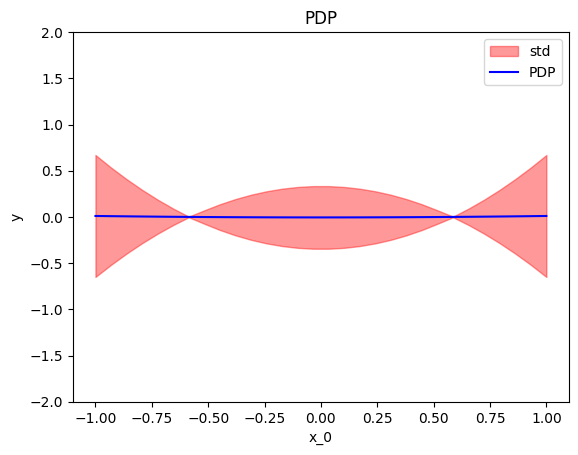

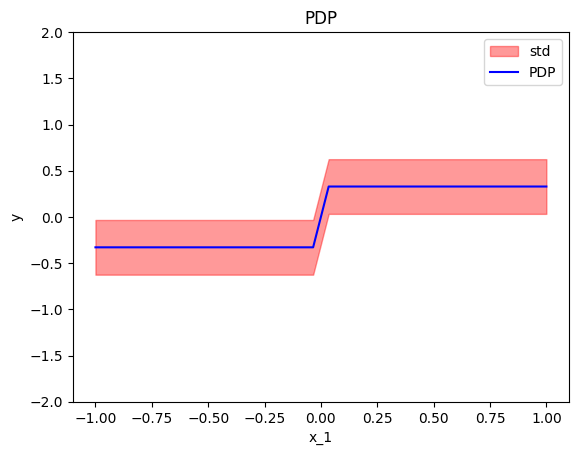

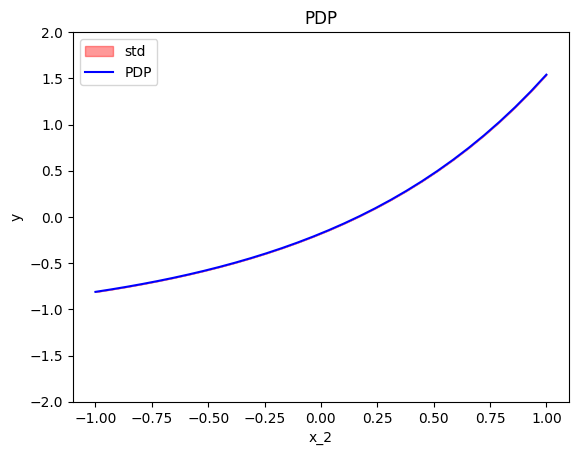

In [2]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits)
pdp.fit(features="all", centering=True)
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

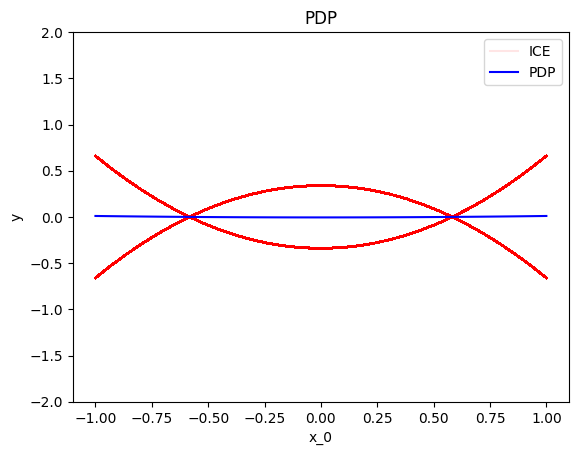

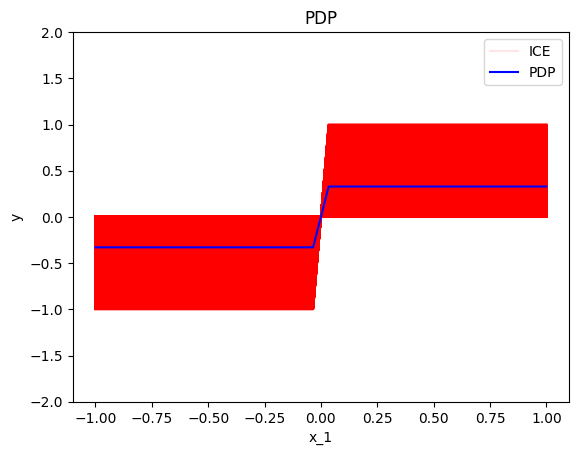

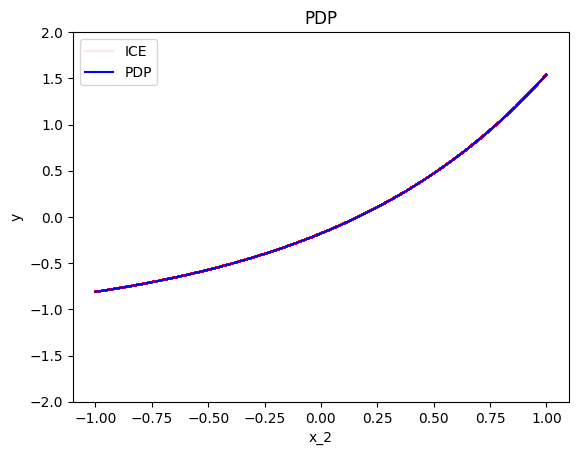

In [3]:
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, heterogeneity="ice", y_limits=[-2, 2])

In [4]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits, nof_instances="all")
pdp.fit(features="all", centering=True)
heter_per_feat = []
for feature in [0, 1, 2]:
    y_mean, y_var = pdp.eval(feature=feature, xs=np.linspace(-1, 1, 100), centering=True, heterogeneity=True)
    print(f"Heterogeneity of x_{feature}: {y_var.mean():.3f}")
    heter_per_feat.append(y_var.mean())

Heterogeneity of x_0: 0.092
Heterogeneity of x_1: 0.088
Heterogeneity of x_2: 0.000


Conclusions:

* The global effect of $x_1$ arises from heterogenous local effects, as $h(x_1) > 0$ for all $x_1$. The std margins (red area of height $\pm h(x_1)$ around the global effect) musleadingly suggest that the heterogeneity is minimized at $x_1 = \pm \frac{2}{3}$. ICE provide a clearer picture; they reveal two groups of effects, $-x_1^2 + c_1$ and $x_1^2 + c_2$. The heterogeneity as a scalar value is $H_{x_1} \approx 0.9$.
* Similar to $x_1$, the global effect of $x_2$ arises from heterogeneous local effects. However, unlike $x_1$, both std margins and ICE plots indicate a constant heterogeneity along all the axis, i.e., $h(x_2) \approx 0.9 \forall x_2$. ICE plots further show a smooth range of varying local effects around the global effect, without distinct groups. The heterogeneity as a scalar is $ H_{x_2} \approx 0.9 $, which is identical to $ H_{x_1} $. This is consistent, as heterogeneity measures the interaction between a feature and all other features. In this case, since only $ x_1 $ and $ x_2 $ interact, their heterogeneity values should be the same.
* $x_3$ shows no heteregeneity; all local effects align perfectly with the global effect.

### Derivations

How PDP (and effector) reached such hetergoneity functions?

For $x_1$:

The average effect is $f^{PDP}(x_1) = 0$. ICE plots are: $-x_1^2 + \frac{1}{3} $ when $x_2^i <0$ and $x_1^2 - \frac{1}{3} $ when $x_2^i \geq 0$. Due to the square, they both create the same deviation from the average effect: $ \left ( x_1^2 - \frac{1}{3} \right )^2 $.

\begin{align}
h(x_1) &= \frac{1}{N} \sum_i^N \left ( f^{ICE,i}_c(x_1) - f^{PDP}_c(x_1) \right )^2 \\
&= \frac{1}{N} \sum_i^N \left ( x_1^2 - \frac{1}{3} \right )^2 \\
&=  x_1^4 - \frac{2}{3} x_1^2 + \frac{1}{9} \\
\end{align}

The heterogeneity as a scalar is simply the mean of the heterogeneity function:

\begin{align}
H_{x_1} &= \frac{ \int_{-1}^{1} \left ( x_1^4 - \frac{2}{3} x_1^2 + \frac{1}{9} \right ) \partial x_1}{2} = \frac{4}{45} \approx 0.9
\end{align}

For $x_2$:

The average effect is $f^{PDP}(x_2) = -\frac{1}{3} \mathbb{1}_{x_2 < 0} + \frac{1}{3} \mathbb{1}_{x_2 \geq 0}$ and the ICE plots are $f^{ICE,i}(x_2) = - (x_1^i)^2 \mathbb{1}_{x_2 < 0} + (x_1^i)^2 \mathbb{1}_{x_2 \geq 0}$.

\begin{align}
h(x_2)  &= \frac{1}{N} \sum_i^N \left ( f^{ICE,i}_c(x_2) - f^{PDP}_c(x_2) \right )^2 \\
&= \frac{1}{N} \sum_i^N \left ( \mathbb{1}_{x_2 < 0} \left ( -\frac{1}{3} + (x_1^i)^2 \right )^2 + \mathbb{1}_{x_2 \geq 0} \left ( -\frac{1}{3} + (x_1^i)^2 \right )^2 \right ) \\
&= \frac{1}{N} \sum_i^N  \left ( -\frac{1}{3} + (x_1^i)^2 \right )^2 \\
&= \frac{4}{45} \approx 0.9
\end{align}

The heterogeneity as a scalar is simply the mean of the heterogeneity function, so:

$$H_{x_2} \approx 0.9$$.

For $x_3$, there is no heterogeneity so $h(x_3)=0$ and $H_{x_3} = 0$.

### Conclusions
PDP heterogeneity provides intuitive insights:

- The global effects of $x_1$ and $x_2$ arise from heterogeneous local effects, while $x_3$ shows no heterogeneity.
- The heterogeneity of $x_1$ and $x_2$ is quantified at the same level (0.99), which makes sense since only these two features interact.
- However, the heterogeneity of $x_1$ appears misleading when centering ICE plots, as it falsely suggests minimized heterogeneity at $\pm \frac{2}{3}$, which is not accurate.

In [5]:
def pdp_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: x**4 - 2/3*x**2 + 1/9
        return ff(xs)
    elif feature == 1:
        ff = lambda x: np.ones_like(x) * 0.088
        return ff(xs)
    elif feature == 2:
        ff = lambda x: np.zeros_like(x)
        return ff(xs)

In [6]:
# make a test
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2]:
    pdp_mean, pdp_heter = pdp.eval(feature=feature, xs=xx, centering=True, heterogeneity=True)
    y_heter = pdp_ground_truth(feature, xx)
    np.testing.assert_allclose(pdp_heter, y_heter, atol=1e-1)

## ALE

### Effector

Let's see below the PDP effects for each feature, using `effector`.

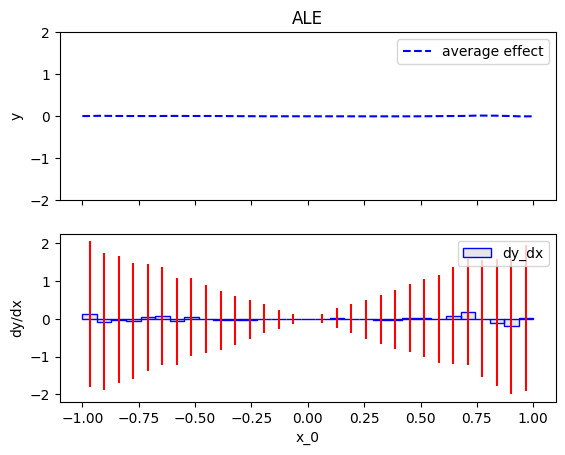

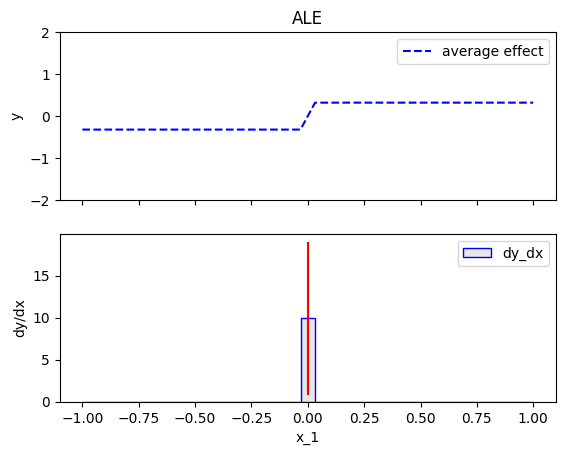

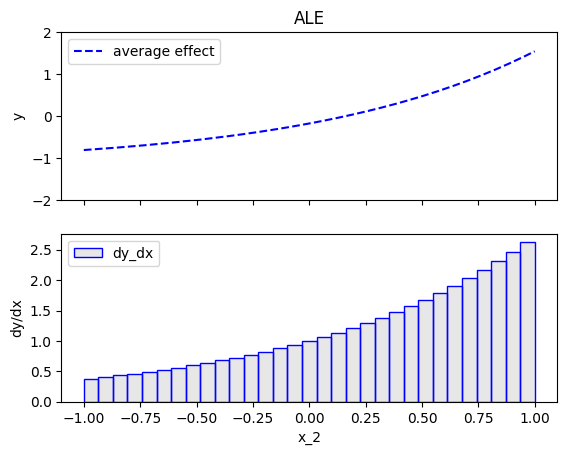

In [7]:
ale = effector.ALE(x, model.predict, axis_limits=dataset.axis_limits)
ale.fit(features="all", centering=True, binning_method=effector.binning_methods.Fixed(nof_bins=31))

for feature in [0, 1, 2]:
    ale.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

ALE states that:

- **Feature $x_1$**:  
  The heterogeneity varies across all values of $x_1$. It starts large at $x_1 = -1$, decreases until it becomes zero at $x_1 = 0$, and then increases again until $x_1 = 1$.  
  This behavior contrasts with the heterogeneity observed in the PDP, which has two zero-points at $x_1 = \pm \frac{2}{3}$.  

- **Feature $x_2$**:  
  Heterogeneity is observed only around $x_2 = 0$. This behavior also contrasts PDP's heterogeneity which is constant for all values of $x_2$

- **Feature $x_3$**:  
  No heterogeneity is present for this feature.  


In [8]:
ale.feature_effect["feature_1"]

{'limits': array([-1.        , -0.93548387, -0.87096774, -0.80645161, -0.74193548,
        -0.67741935, -0.61290323, -0.5483871 , -0.48387097, -0.41935484,
        -0.35483871, -0.29032258, -0.22580645, -0.16129032, -0.09677419,
        -0.03225806,  0.03225806,  0.09677419,  0.16129032,  0.22580645,
         0.29032258,  0.35483871,  0.41935484,  0.48387097,  0.5483871 ,
         0.61290323,  0.67741935,  0.74193548,  0.80645161,  0.87096774,
         0.93548387,  1.00000001]),
 'dx': array([0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
        0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
        0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
        0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
        0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
        0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
        0.06451614]),
 'points_per_bin': array([320, 339, 318, 345, 313, 312, 331, 311, 293, 326, 309,

### Derivations

For x_1:

The $x_1$-axis is divided into $K$ equal bins, indexed by $k = 1, \ldots, K$, with the center of the $k$-th bin denoted as $c_k$. 
In each bin: if $x_2 < 0$, the local effects is $-2c_k$, and if $x_2 \geq 0$ the local effect is $2 c_k$. 
This gives a variance of $4c_k^2$ within each bin.
Therefore, $h(x_1) = 4c_k^2$ where $k$ is the index of the bin that contains $x_1$. 

\begin{align}
h(x_1) &= \frac{1}{|\mathcal{S}_k|} \sum_{\mathbf{x}^i \in \mathcal{S}_k} \left ( \frac{f(z_k, x_2^i, x_3^i) - f(z_{k-1}, x_2^i, x_3^i)}{z_k - z_{k-1}} - \hat{\mu}_k^{ALE}  \right )^2 \\
&=  \frac{1}{|\mathcal{S}_k|} \sum_{\mathbf{x}^i \in \mathcal{S}_k} \left ( \frac{-2c_k(z_k - z_{k-1}) \mathbb{1}_{x_2^i < 0} + 2c_k(z_k - z_{k-1}) \mathbb{1}_{x_2^i \geq 0}}{z_k - z_{k-1}} \right )^2 \\
&=  \frac{1}{|\mathcal{S}_k|} \sum_{\mathbf{x}^i \in \mathcal{S}_k} 4 c_k^2 \\
&=  4 c_k^2
\end{align}

For $x_2$:

In all bins except the central one, the local effects are zero. In the central bin, however, the local effects are $ 2(x_1^i)^2 $, which introduces some heterogeneity.
So, if $ x_2 $ is not in the central bin $ k = K/2 $, $h(x_2) = 0$.
If $ x_2 $ is in the central bin $ k = K/2 $:

\begin{align}
h(x_2) &= \frac{1}{|\mathcal{S}_k|} \sum_{\mathbf{x}^i \in \mathcal{S}_k} \left( \frac{f(z_k, x_2^i, x_3^i) - f(z_{k-1}, x_2^i, x_3^i)}{z_k - z_{k-1}} - \hat{\mu}_k^{ALE} \right)^2 \\
&= \frac{2}{z_k - z_{k-1}} \frac{1}{|\mathcal{S}_k|} \sum_{\mathbf{x}^i \in \mathcal{S}_k} (x_1^i)^2 \\
&= \frac{2}{3}(z_k - z_{k-1}) \\
&\approx 10 \text{ for } K=31
\end{align}

So: 
\begin{align}
h(x_2)
&=  \begin{cases} 
0, & \text{if } x_2 \text{ is not in the central bin (}\ k = K/2\text{)}, \\
\frac{31}{3} \approx 10 & \text{if } x_2 \text{ is in the central bin (}\ k = K/2\text{)}. 
\end{cases} \\
\end{align}

For $x_3$:

The effect is zero everywehere.

In [9]:
def ale_ground_truth(feature):
    K = 31
    bin_centers = np.linspace(-1 + 1/K, 1 - 1/K, K)
    if feature == 0:
        return 4*bin_centers**2
    elif feature == 1:
        y = np.zeros_like(bin_centers)
        y[15] = None
        return y
    elif feature == 2:
        return np.zeros_like(bin_centers)

In [10]:
# make a test
K = 31
bin_centers = np.linspace(-1 + 1/K, 1 - 1/K, K)
for feature in [0, 1, 2]:
    bin_var = ale.feature_effect[f"feature_{feature}"]["bin_variance"]
    gt_var = ale_ground_truth(feature)
    mask = ~np.isnan(gt_var)
    np.testing.assert_allclose(bin_var[mask], gt_var[mask], atol=1e-1)

### Conclusions

Is the heterogeneity implied by the ALE plots meaningful?
It is

## RHALE

### Effector

Let's see below the RHALE effects for each feature, using `effector`.

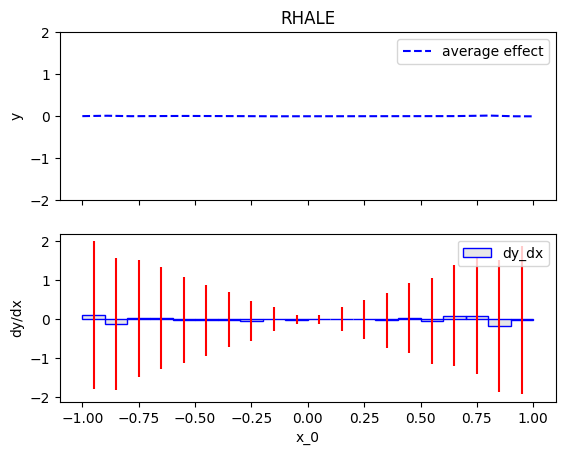

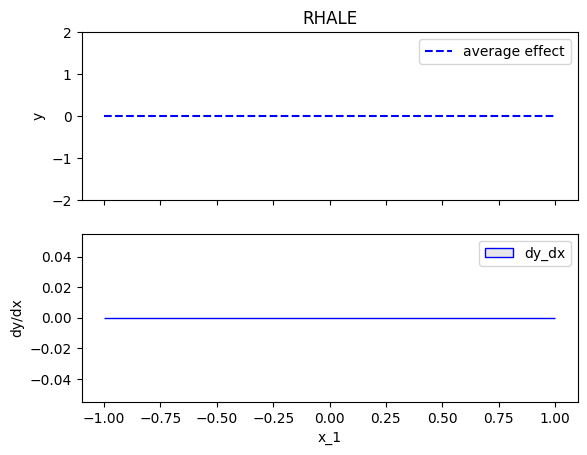

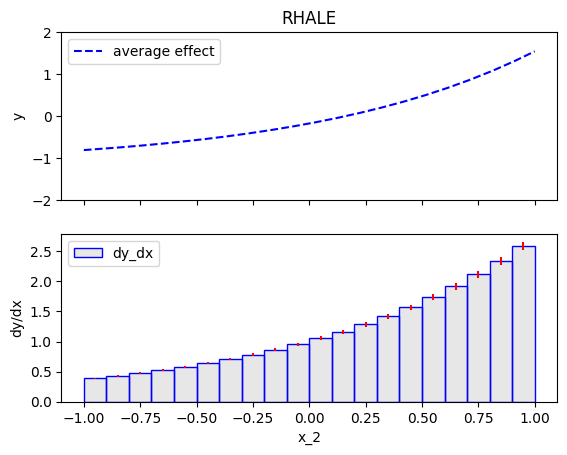

In [11]:
rhale = effector.RHALE(x, model.predict, model.jacobian, axis_limits=dataset.axis_limits)
rhale.fit(features="all", centering=True)

for feature in [0, 1, 2]:
    rhale.plot(feature=feature, centering=True, heterogeneity=True, y_limits=[-2, 2])

RHALE states that:

- **Feature $x_1$**:
  As in ALE, the heterogeneity varies across all values of $x_1$. It starts large at $x_1 = -1$, decreases until it becomes zero at $x_1 = 0$, and then increases again until $x_1 = 1$.  

- **Feature $x_2$**:  
  No heterogeneity is present for this feature.

- **Feature $x_3$**:  
  No heterogeneity is present for this feature.  


### Derivations

\begin{align}
H(x_1) &\approx
\end{align}

\begin{align}
H(x_2) &\approx
\end{align}

\begin{align}
H(x_3) &\approx
\end{align}

### Conclusions

Are the RHALE effects intuitive?